In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hackerStats import dcst # Custom written hacker statistics functions

In [2]:
sns.set()

# Activity of zebrafish and melatonin
## EDA

Plot an ECDF of active bout length for the mutant and wild type fish for the seventh night of their lives. <br>
The bout lengths appear Exponentially distributed, which implies that exiting an active bout to rest is a Poisson process; the fish have no apparent memory about when they became active.<br>

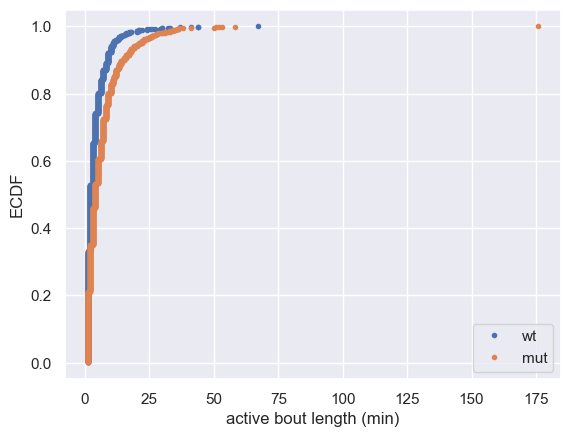

In [3]:
# load and prepare data
df = pd.read_csv('datasets/gandhi_et_al_bouts.csv', skiprows=4)
# Bout lengths for each genotype
bout_lengths_wt = df[df['genotype'] == 'wt']['bout_length'].to_numpy()
bout_lengths_mut = df[df['genotype'] == 'mut']['bout_length'].to_numpy()
bout_lengths_het = df[df['genotype'] == 'het']['bout_length'].to_numpy()
# Generate x and y values for plotting ECDFs
x_wt, y_wt = dcst.ecdf(bout_lengths_wt)
x_mut, y_mut = dcst.ecdf(bout_lengths_mut)

# Plot the ECDFs
_ = plt.plot(x_wt, y_wt, marker='.', linestyle='none')
_ = plt.plot(x_mut, y_mut, marker='.', linestyle='none')

# Make a legend, label axes, and show plot
_ = plt.legend(('wt', 'mut'))
_ = plt.xlabel('active bout length (min)')
_ = plt.ylabel('ECDF')
plt.show()


## Parameter estimation: active bout length

Compute the mean active bout length for wild type and mutant, with 95% bootstrap confidence interval.<br>
The confidence intervals are quite separated.

In [4]:
# Compute mean active bout length
mean_wt = np.mean(bout_lengths_wt)
mean_mut = np.mean(bout_lengths_mut)

# Draw bootstrap replicates
bs_reps_wt = dcst.draw_bs_reps(bout_lengths_wt, np.mean, size=10 ** 4)
bs_reps_mut = dcst.draw_bs_reps(bout_lengths_mut, np.mean, size=10 ** 4)

# Compute 95% confidence intervals
conf_int_wt = np.percentile(bs_reps_wt, [2.5, 97.5])
conf_int_mut = np.percentile(bs_reps_mut, [2.5, 97.5])

# Print the results
print("""
wt:  mean = {0:.3f} min., conf. int. = [{1:.1f}, {2:.1f}] min.
mut: mean = {3:.3f} min., conf. int. = [{4:.1f}, {5:.1f}] min.
""".format(mean_wt, *conf_int_wt, mean_mut, *conf_int_mut))


wt:  mean = 3.874 min., conf. int. = [3.6, 4.1] min.
mut: mean = 6.543 min., conf. int. = [6.1, 7.0] min.



## Permutation test: wild type versus heterozygote

Test the hypothesis that the heterozygote and wild type bout lengths are identically distributed using a permutation test.<br>
A p-value of around 0.001 suggests that the observed difference in means is unlikely to occur if heterozygotic and wild type fish have active bout lengths that are identically distributed.

In [5]:
# Compute the difference of means: diff_means_exp
diff_means_exp = np.mean(bout_lengths_het) - np.mean(bout_lengths_wt)

# Draw permutation replicates: perm_reps
perm_reps = dcst.draw_perm_reps(bout_lengths_het, bout_lengths_wt, 
                               dcst.diff_of_means, size=10 ** 4)

# Compute the p-value: p-val
p_val = np.sum(perm_reps >= diff_means_exp) / len(perm_reps)

# Print the result
print('p =', p_val)

p = 0.0014


## Bootstrap hypothesis test

We get a result of similar magnitude as the permutation test, though slightly smaller, probably because the heterozygote bout length distribution has a heavier tail to the right.

In [6]:
# Concatenate arrays: bout_lengths_concat
bout_lengths_concat = np.concatenate((bout_lengths_wt, bout_lengths_het))

# Compute mean of all bout_lengths: mean_bout_length
mean_bout_length = np.mean(bout_lengths_concat)

# Generate shifted arrays
wt_shifted = bout_lengths_wt - np.mean(bout_lengths_wt) + mean_bout_length
het_shifted = bout_lengths_het - np.mean(bout_lengths_het) + mean_bout_length

# Compute 10,000 bootstrap replicates from shifted arrays
bs_reps_wt = dcst.draw_bs_reps(wt_shifted, np.mean, 10 ** 4)
bs_reps_het = dcst.draw_bs_reps(het_shifted, np.mean, 10 ** 4)

# Get replicates of difference of means: bs_replicates
bs_reps = bs_reps_het - bs_reps_wt

# Compute and print p-value: p
p = np.sum(bs_reps >= diff_means_exp) / len(bs_reps)
print('p-value =', p)

p-value = 0.0006


# Bacteria growth rate
## Assessing the growth rate

Compute the growth rate and get a 95% confidence interval using pairs bootstrap.<br>
Under these conditions, the bacterial mass doubles about every three hours. The error bar is also very tight.

In [7]:
# Load and prepare the data
df = pd.read_csv('datasets/park_bacterial_growth.csv', skiprows=2)
bac_area = df[df.columns[0]].to_numpy()
t = df[df.columns[1]].to_numpy()
# Compute logarithm of the bacterial area: log_bac_area
log_bac_area = np.log(bac_area)

# Compute the slope and intercept: growth_rate, log_a0
growth_rate, log_a0 = np.polyfit(t, log_bac_area, deg=1)

# Draw 10,000 pairs bootstrap replicates: growth_rate_bs_reps, log_a0_bs_reps
growth_rate_bs_reps, log_a0_bs_reps = dcst.draw_bs_pairs_linreg(
    t, log_bac_area, size=10 ** 4
)
    
# Compute confidence intervals: growth_rate_conf_int
growth_rate_conf_int = np.percentile(growth_rate_bs_reps, [2.5, 97.5])

# Print the result to the screen
print("""
Growth rate: {0:.4f} 1/hour
95% conf int: [{1:.4f}, {2:.4f}] 1/hour
""".format(growth_rate, *growth_rate_conf_int))


Growth rate: 0.2301 1/hour
95% conf int: [0.2267, 0.2336] 1/hour



## Plotting the growth curve (EDA)
Explore the confidence interval of growth rate graphically by plotting several bootstrap lines along with the growth curve.<br>
the bootstrap replicates do not stray much. This is due to the exquisitly exponential nature of the bacterial growth under these experimental conditions.

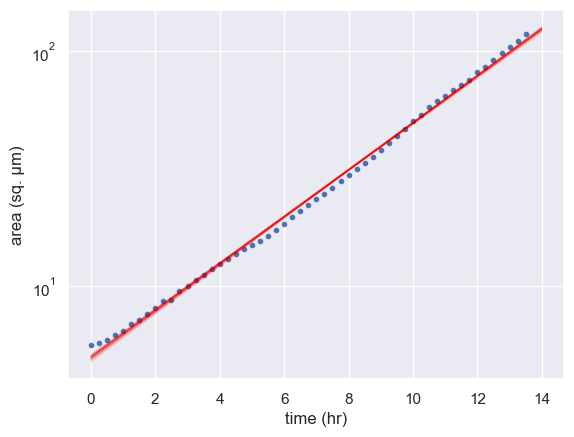

In [8]:
# Plot data points in a semilog-y plot with axis labeles
_ = plt.semilogy(t, bac_area, marker='.', linestyle='none')

# Generate x-values for the bootstrap lines: t_bs
t_bs = np.array([0, 14])

# Plot the first 100 bootstrap lines
for i in range(100):
    y = np.exp(growth_rate_bs_reps[i] * t_bs + log_a0_bs_reps[i])
    _ = plt.semilogy(t_bs, y, linewidth=0.5, alpha=0.05, color='red')
    
# Label axes and show plot
_ = plt.xlabel('time (hr)')
_ = plt.ylabel('area (sq. µm)')
plt.show()